In [1]:
import glob
import os, re
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split


txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:10])

데이터 크기: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?", 'It goes like this', 'The fourth, the fifth', 'The minor fall, the major lift', 'The baffled king composing Hallelujah Hallelujah', 'Hallelujah', 'Hallelujah', 'Hallelujah Your faith was strong but you needed proof']


In [2]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

In [3]:
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0:
        continue
    preprocessed_sentence = preprocess_sentence(sentence)
    if len(preprocessed_sentence.split()) > 15:
        continue
    
#     preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)

처음에 어떻게 해야 텐서가 15개를 넘어가는 것을 제외해야 될지 몰라서 고민하며 파이썬 문법을 보다 보니
아주 간단하게 split() 메서드를 통해 분해할 수 있어서 사용했다

근데 이게 맞는지는 모르겠다.

In [4]:
corpus[:10]

['<start> now i ve heard there was a secret chord <end>',
 '<start> that david played , and it pleased the lord <end>',
 '<start> but you don t really care for music , do you ? <end>',
 '<start> it goes like this <end>',
 '<start> the fourth , the fifth <end>',
 '<start> the minor fall , the major lift <end>',
 '<start> the baffled king composing hallelujah hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah your faith was strong but you needed proof <end>']

In [5]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=20000, filters=' ', oov_token="<unknown>")
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    print(tensor, tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2   50    4 ...    0    0    0]
 [   2   15 2971 ...    0    0    0]
 [   2   33    7 ...   46    3    0]
 ...
 [   2    4  117 ...    0    0    0]
 [   2  258  195 ...   12    3    0]
 [   2    7   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f247d351190>


단어장의 크기를 

In [6]:
print(tensor[:3, :10])
print(type(tensor))

[[   2   50    4   95  303   62   53    9  946 6269]
 [   2   15 2971  872    5    8   11 5747    6  374]
 [   2   33    7   40   16  164  288   28  333    5]]
<class 'numpy.ndarray'>


In [7]:
source_input = tensor[:, :-1]  
target_input = tensor[:, 1:]    

enc_train, enc_val, dec_train, dec_val = train_test_split(source_input, target_input, test_size=0.2, random_state=43)

print("source train :", enc_train.shape)
print("Target train : ", dec_train.shape)

source train : (124981, 14)
Target train :  (124981, 14)


In [8]:
# BUFFER_SIZE = len(source_input)
# BATCH_SIZE = 256
# steps_per_epoch = len(source_input) // BATCH_SIZE

# VOCAB_SIZE = tokenizer.num_words + 1

# dataset = tf.data.Dataset.from_tensor_slices((source_input, target_input))
# dataset = dataset.shuffle(BUFFER_SIZE)
# dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
# dataset

In [9]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size, hidden_size)


embedding_size에 대해서 어떤 값을 취해주는지 가장 적절할지 몰라
처음에 embedding_size = 1000, hidden_size = 3000을 넣어 줬다(돌리는데 3시간 반걸렸다)
이후 로스율이 2.48까지밖에 나오지 않아
다시 40, 1024로 바꿔줬으나 오히려 val_loss가 2.6으로 올라갔다

너무 많아도 문제지만 너무 적은 것 일까?? 적절한 embedding_size를 추측하는 방법이 검색해도 잘 나오지 않는다

그나마 embedding에 대한 값을 구하는 블로그인데 넘모 어렵다

https://paul-hyun.github.io/transformer-01/

In [10]:
optimizer = tf.keras.optimizers.Adam()
# optimizer = tf.keras.optimizers.RMSprop()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)
history = model.fit(enc_train, dec_train, epochs=5, validation_data=(enc_val, dec_val))

Epoch 1/5
3906/3906 [==============================] - 530s 130ms/step - loss: 3.1059 - val_loss: 2.8252
Epoch 2/5
3906/3906 [==============================] - 514s 132ms/step - loss: 2.5968 - val_loss: 2.5774
Epoch 3/5
3906/3906 [==============================] - 515s 132ms/step - loss: 2.1793 - val_loss: 2.4195
Epoch 4/5
3906/3906 [==============================] - 515s 132ms/step - loss: 1.8085 - val_loss: 2.3440
Epoch 5/5
3906/3906 [==============================] - 516s 132ms/step - loss: 1.5227 - val_loss: 2.3243


>#### optimizer를 RMSprop로 바꾸는 방법도 있기에 한번 시도해 봤다
RMSprop를 사용하여 최적화를 하는 방법이 더 잘 어울릴지 궁금하다  
처음 시작은 3.0으로 시작해서 아주 좋은 시작이라고 생각했지만, val_loss의 감소하질 않는다 최저가 2.9이고 6번째 이후 부터는 다시 3.0으로 올라간다 마지막엔 3.1까지 올라갔다 영 파이다  
이에 대한 문제는 embedding_size, hidden_size의 설정 혹은 지금의 데이터가 RMSprop과 맞지 않기 때문이지 않을까??   
명확한 정답은 RMSprop을 잘 모르기 때문에 일단 지금의 경우는 adam 보다 떨어진다고 생각하고 넘어간다  

>Epoch 5번째를 기준으로 그 이상 학습을 하면 학습 loss율은 하락하지만 테스트 loss율은 커지는 과대 적합이 일어나 epoch를 10에서 5로 줄여주었다  

한번에 돌리기에는 너무 많은 것 같아 batch_size를 1000으로 지정해줬다

batch_size를 1000으로 지정해주니 125개씩만 훈련을 해서 너무 적은 훈련을 했다
왜 그럴까??
내가 이해하기로는 batch_size를 지정해주면 1000으로 나눠 전체적인 반복을 진행할 것이라 생각했지만 그렇지 않았다




In [11]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  5120256   
_________________________________________________________________
lstm (LSTM)                  multiple                  18882560  
_________________________________________________________________
lstm_1 (LSTM)                multiple                  33562624  
_________________________________________________________________
dense (Dense)                multiple                  40982049  
Total params: 98,547,489
Trainable params: 98,547,489
Non-trainable params: 0
_________________________________________________________________


In [12]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]
    
    while True:
        predict = model(test_tensor)
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        if predict_word.numpy()[0] == end_token:
            break
        if test_tensor.shape[1] >= max_len: 
            break

    generated = ""
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [13]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , bye bye <end> '

참고 사이트

https://nicola-ml.tistory.com/108


In [14]:
import matplotlib.pyplot as plt
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

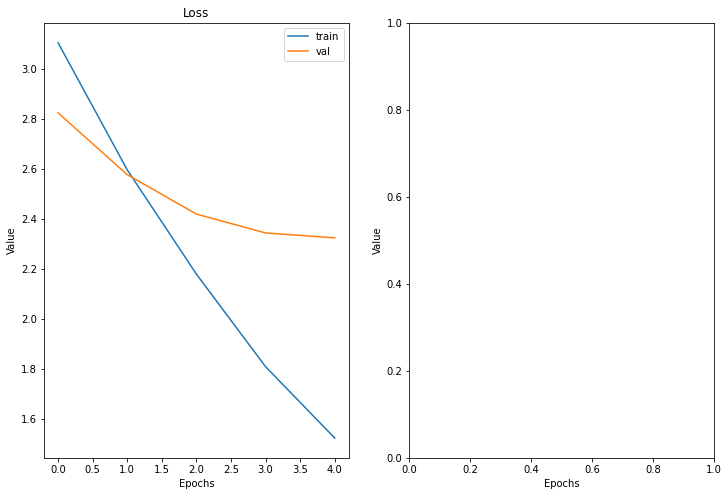

In [15]:
plot_curve(history.epoch, history.history, ['loss', 'val_loss'])

위 코드는 서치하다가 발견한 시각화 코드이다 loss 값을 그래프로 확인한다
(근데 그 블로그에는 표가 한개만 있는데 왜 두개지??)

학습을 계속 진행하면 할 수록 오히려 과대적합되는 모양을 보인다(까먹고 캡쳐 안했다....)



많은 학습하는데 너무 많은 시간을 소모하기 때문에 다양한 방법을 사용해보지는 못했다.(다른 노드도 해야되기 때문에)  
(참고로 근 3주만에 깨달은 것이 노드를 변경하면 주피터 노트북의 환경도 바뀌기 때문에 연결이 끊기게 되더라..... 왜 맨날 끊기지 했는데)
학습하는 동안 효율적으로 다른 노드를 공부하려던 계획이 무산되었다 빨리 로컬에 tensorflow 등을 설치하고 세팅할 필요성을 느끼고 있다.

여러가지 시도를 해보면서 다양한 결과값을 얻고 싶었지만 시간 핑계를 대면서 마무리 한다.
이번 의문들을 기록해둔채 다음에 다시 보면 더 충만한 지식으로 쉽게 문제를 해결하길 바라면서

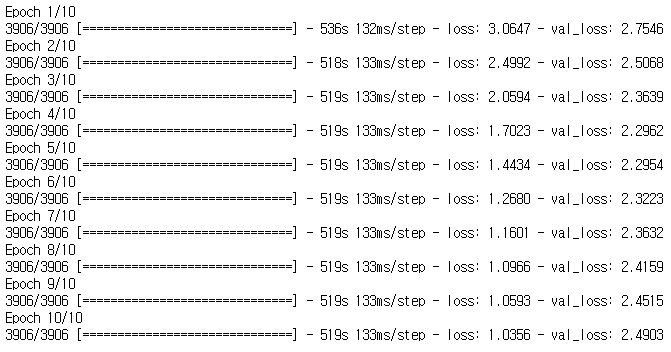


최저 val_loss 값이 약 2.32가 나온다